# JuliaCon - MMM Demo - Detailed

Example application of Media Mix Modelling to optimize marketing spend

High-level workflow:
- Input and transform data 
    - Provide column names of the corresponding to groups of variables (eg, `cols_spend` for Adspend variables to be modelled)
    - Variables that can have positive-only effects will be standardized to 0-1 range
    - Variables with any-signed effects will be at least standardized via Z-Score
- Set priors / conversion factors
    - Ie, use your domain knowledge to set realistic marketing transforms' parameters
- Stage 1: Fit the trend
    - Extract separate series for growth trend, seasonality, holidays, organic variables 
- Stage 2: Fit the coefficients for marketing transformation
    - Validate the fit (Rhat, traceplots, etc)
- Quantify the contributions + ROAS of the current marketing spend
- Optimize the marketing budget to maximize the marketing contribution 
    - Define a loss function that reflects your business' decision-making process
    - Evaluate the results of the optimization + inherent uncertainty
    
For more details on the methodology and practical tips visit [MMM Demo Docs](https://svilupp.github.io/JuliaCon2022/dev/)

In [1]:
using Pkg; Pkg.activate(".");

  Activating project at `~/Documents/julia-con-2022/MediaMixModellingDemo`


In [2]:
using Printf
import Splines2
import Optim
import Metaheuristics
using BenchmarkTools
using Logging

In [3]:
# use Revise for interactive workflow
using Revise
using MediaMixModellingDemo
# MMM reexports: Turing,DataFramesMeta,Distributions,TableTransforms,Plots,StatsPlots

┌ Info: Precompiling MediaMixModellingDemo [4e93a9b9-a149-4ac6-a861-ccd6e00daaca]
└ @ Base loading.jl:1423


In [4]:
ENV["LINES"]=200
ENV["COLUMNS"]=600
Threads.nthreads();

## Generate

Let's generate some example data where we know "truth", so we can test this implementation

┌ Info: INDEX with 105 observations generated (random seed=0)
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/data_generation.jl:131
┌ Info: TREND: Trend offset of 0.4 / Total growth of 0.2
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/data_generation.jl:139
┌ Info: SEASONALITY: Series with periods 4 generated
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/data_generation.jl:154
┌ Info: HOLIDAYS: Number of days: 5
│  Average effect: -0.2
│  Total effect: -1.1
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/data_generation.jl:166
┌ Info: EVENTS: 0 events generated with coefficients: 0
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/data_generation.jl:180
┌ Info: Marketing Variables: 
│ (label = "facebook_S", mean = 0.4, std = 0.2, sparsity = 1.0, decay_rate = 0.5, halfpoin

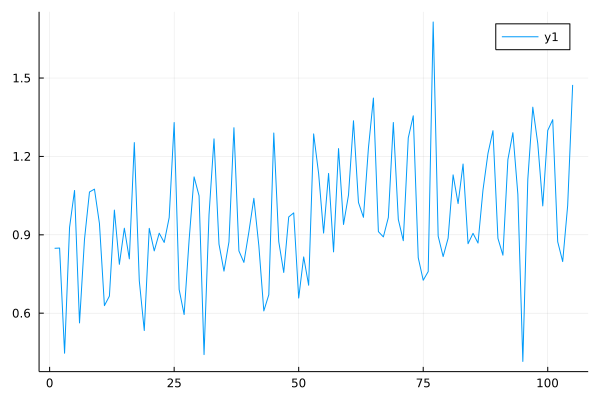

In [5]:
Y,X,col_names=create_dataset("2020-02-01",105,0);

# Let's apply standard notation of df being the source of data
df=X
df[!,:revenue]=vec(sum.(eachrow(Y)));

plot(df.revenue)

# Modelling 

We will fit the model in 2 stages to deal with the under-specification.

As a convention the deterministic location of the observed variable (mean of the RV `y`) will be called `mu` and its components will be all prefixed as such, eg, 
- `mu_trend` for the trend component, 
- `mu_seas` for the seasonality component, 
- `mu_hols` for the holidays component,
- `mu_context` for the contributions of the contextual variables,
- `mu_org`
- `mu_spend` for the contribution of all Ad spend variables together
- `mu_spend_by_var` for the contributions of each individual spend variables (ie, number of columns = number of Ad spend variables)

(See `src/model_definition.jl` for more details)

All these deterministic components will be exposed by DynamicPPL in the return statement to be easily extracted via `generated_quantities()` conditioned on fitted samples (a `chains` object). In other words, given a model fit, we can easily extract all the above components by playing the samples through the model.

In [6]:
# Model used in stage1
const MODEL_NAME_PREFIT="model_stage1a"
model_func_stage1=getfield(MediaMixModellingDemo,Symbol(MODEL_NAME_PREFIT))

# Model used in stage2
const MODEL_NAME="model_stage2a"
model_func_stage2=getfield(MediaMixModellingDemo,Symbol(MODEL_NAME))

# Runs on the whole period at the moment, but allows for fitting on only the most recent data (or cross-validation)
const FITTING_MASK=trues(nrow(df)) 

# Modifier of chart titles
const EXPERIMENT_NAME=" JuliaCon"
pplot=ParamsPlot(title_suffix=EXPERIMENT_NAME)
;

## Data

Let's identify seasonalities in our data (for trend modelling)

Pick the ones with the highest value (usually only 1 or 2 max)

#1 period: 4.0 with 10.0
#2 period: 105.0 with 5.3
#3 period: 35.0 with 3.7


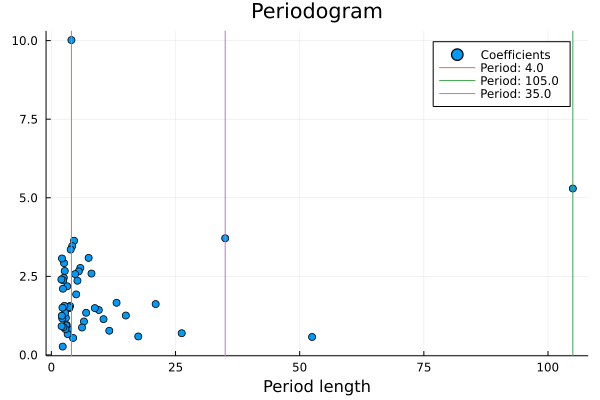

In [8]:
# what's the seasonality
plot_periodogram(df.revenue .- mean(df.revenue),3)

In [9]:
### Y transform
target_label=:revenue
y_true=df[!,target_label]
y_std,pipe_cache_y=standardize_by_max(select(df,target_label))
y_std=y_std[!,1]

# define revert function
revert_pipe_y= y->revert(MinMax(), (;y),pipe_cache_y).y

### FEATURES
# positive coefficient, not transformed (saturated etc)
cols_organic=["newsletters"]
X_org,pipe_cache_org=standardize_by_max(convert.(Float64,df[!,cols_organic]))

# positive coeffcients, transformed
cols_spend=col_names.cols_spend
X_spend,pipe_cache_spend=standardize_by_max(convert.(Float64,df[!,cols_spend]))

# revert function utility
revert_pipe_spend=x->revert(MinMax(),x,pipe_cache_spend)

# any coefficient
cols_context=[c for c in col_names.cols_context if !(c in cols_organic)]
X_context,pipe_cache_context=standardize_by_zscore(convert.(Float64,df[!,cols_context]))

# categorical
cols_cat=["events"]
cat_levels=1
# must be a vector
X_cat=df[!,cols_cat[1]] .|> levelcode;

# No transformation
cols_hols=["hols_ind"]
X_hols=df[!,cols_hols]

X_feat=hcat(X_spend,X_org,X_context);

time_std=df.time_std
@show time_std|>size time_std|>extrema

# a trick to fit changing trends etc.
# X_trend=Splines2.bs(time_std,df=3,boundary_knots=(-eps(),1+eps()));
# @show X_trend|>size X_trend|>extrema

# Do not provide X_trend if your trend is simple
# It could overfit - there is a growth term, an offset and a seasonality already! 
# Use it on complicated datasets / with larger datasets
X_trend=nothing

# Seasonality (set to 4 periods here)
seasonality_arr=[(4/(length(time_std)-1),3,"4")]
X_seas=generate_seasonality_features(time_std, seasonality_arr);
first(X_seas)

time_std |> size = (105,)
time_std |> extrema = (0.0, 1.0)


,seasonality4_01,seasonality4_02,seasonality4_03,seasonality4_04,seasonality4_05,seasonality4_06
,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,1.0,0.0,0.0,0.0


**Requirements to proceed:**

- Code base depends on variables under the following names:
    - X_spend: DataFrame of adspend to be transformed (only positive coefficients will be allowed)
    - X_org: DataFrame of organic variables (ie, only positive coefficients will be allowed)
    - X_cat: 1-column DataFrame with a categorical variable (eg, for events)
    - X_hols: DataFrame with holiday events (currently, 1-column with dummy encoding of holiday effect)
    - X_context: Any context variables (eg, market drivers, market index, competitor popularity)

    - X_seas: Created seasonality DataFrame
    - X_feat: horizontal concatenation of X_spend,X_org,X_content (order does not matter)
    - X_trend: Optional - Spline-basis for flexible trend modelling
    
    - y_std: transformed response variable
    - y_true: original response variable (=revenues)
    - time_std: transformed time index running from 0-1 during the whole period (important for setting priors)
    
    - cols_spend: Vector of ad spend variables in the same order as `X_spend` (ie, `names(X_spend)`)
    - cat_levels: Integer of how many levels are in the 1-column DataFrame `X_cat`
    
- Transformations caches saved under pipe_cache_y,pipe_cache_spend
    - pipe_cache_y: TableTransforms cache to revert y-variable transform
    - pipe_cache_spend: TableTransforms cache to revert X_spend variables transform

- Functions:
    - revert_pipe_y: utility to revert transformation of y-variable
    - revert_pipe_spend: utility to revert transformation of the ad spend variables
    
Reason: Most of them are used when setting conversion ratios and priors in `ParamsStage1` and `ParamsStage2`

In [10]:
# Run some basic checks
@assert @isdefined(X_spend)
@assert cols_spend==names(X_spend)

@assert @isdefined(X_hols) && @isdefined(X_org) && @isdefined(X_cat) && @isdefined(X_context)
@assert @isdefined(X_feat) && @isdefined(X_seas) && @isdefined(X_trend)
@assert @isdefined(cat_levels) && cat_levels isa Integer

@assert @isdefined(y_std) && @isdefined(y_true) && @isdefined(time_std)
@assert time_std|>extrema == (0.0, 1.0)

@assert size(y_std,1) == size(X_spend,1) == size(X_hols,1) == size(X_org,1) == size(X_cat,1) == size(X_context,1)
@assert size(y_std,1) == size(X_feat,1) == size(X_seas,1) # == size(X_trend,1)
@assert size(y_std,1) == size(time_std,1) == size(y_true,1)

@assert @isdefined(pipe_cache_y) && @isdefined(pipe_cache_spend)

@assert @isdefined(revert_pipe_y)
@assert @isdefined(revert_pipe_spend)

## Stage 1 - Prophet-like model

Let's fit a model to the trend, seasonality and holidays

We do not adstock/saturate the marketing spend at this stage

In [11]:
p1=ParamsStage1(
    model_name=Val(Symbol(MODEL_NAME_PREFIT)),
    scales_trend=0.2,
    scales_hols=0.3,
    scales_noise=0.2,
    cat_levels=1
)
p1=set_priors_stage1_trendline(y_std,p1)
p1=set_priors_auto_scales(y_std,X_seas,:scales_seas,1.0,p1)
p1=set_priors_auto_scales(y_std,X_feat,:scales_feat,1.0,p1)

sanity_check_priors(p1;X_seas,X_feat,X_trend,X_hols);

┌ Info: Trendline:
│   scales_trend_offset = 0.45741119137901
│   scales_growth_trend = 1.737099382015156
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/model_priors.jl:63
┌ Info: Key scales_seas: 0.20 | 0.14 | 0.20 | 0.20 | 10.00 | 0.20  Warnings: A variable hit maximum allowed scale! Set to 10.0!
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/model_priors.jl:104
┌ Info: Key scales_feat: 0.67 | 0.36 | 0.53 | 0.49 | 0.14 | 0.14
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/model_priors.jl:104


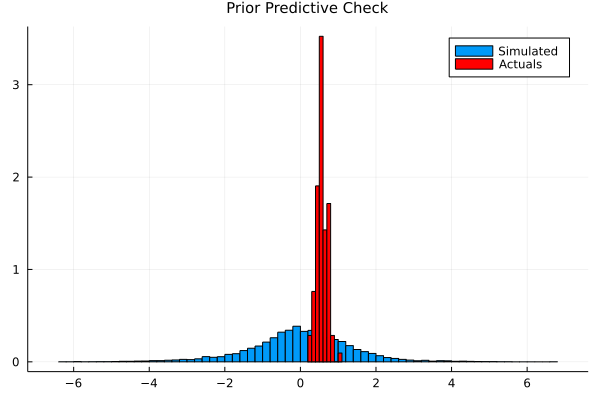

In [12]:
model_orig_stage1=model_func_stage1(time_std,
    to_masked_matrix(X_trend),
    to_masked_matrix(X_hols),
    to_masked_matrix(X_seas),
    to_masked_matrix(X_feat),
    to_masked_matrix(X_cat),p1);
cond_model_stage1=model_orig_stage1 | (;y=y_std);

y_prior=mapreduce(x->rand(model_orig_stage1).y,hcat,1:100)|>vec
plot_prior_predictive_histogram(y_std,y_prior,ParamsPlot())

In [13]:
# used to benchmark implementation of the core function
@btime cond_model_stage1.f(
    cond_model_stage1,
    Turing.VarInfo(cond_model_stage1),
    Turing.SamplingContext(
        Random.GLOBAL_RNG, Turing.SampleFromPrior(), cond_model_stage1.context,
    ),
    cond_model_stage1.args...,
);

  91.459 μs (855 allocations: 64.97 KiB)


### NUTS

In [14]:
max_depth=10
chain_stage1 = sample(cond_model_stage1, NUTS(300,0.65;max_depth),MCMCSerial(),100,1) 

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/simljx/.julia/packages/Turing/JdESU/src/inference/hmc.jl:188
Sampling (Chain 1 of 1): 100%|██████████████████████████| Time: 0:00:02


Chains MCMC chain (100×28×1 Array{Float64, 3}):

Iterations        = 301:1:400
Number of chains  = 1
Samples per chain = 100
Wall duration     = 12.89 seconds
Compute duration  = 12.89 seconds
parameters        = growth_trend, beta_hols[1], beta_seas[1], beta_seas[2], beta_seas[3], beta_seas[4], beta_seas[5], beta_seas[6], beta_feat[1], beta_feat[2], beta_feat[3], beta_feat[4], beta_feat[5], beta_feat[6], alpha[1], sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
    parameters      mean       std   naive_se      mcse        ess      rhat   ess_per_sec 
        Symbol   Float64   Float64    Float64   Float64    Float64   Float64       Float64 

  growth_trend    0.1097    0.0241     0.0024    0.0025    53.5720    0.9920        4.1574
  beta_hols[1]   -0.1440    0.0348     0.0035    0.0026   100.1214    0.990

In [15]:
quick_nuts_diagnostics(chain_stage1,max_depth)

Acceptance rate is: 87.5%
Number of all numerical errors: 0.0
Number of transitions that exceeded max depth of 10: 0


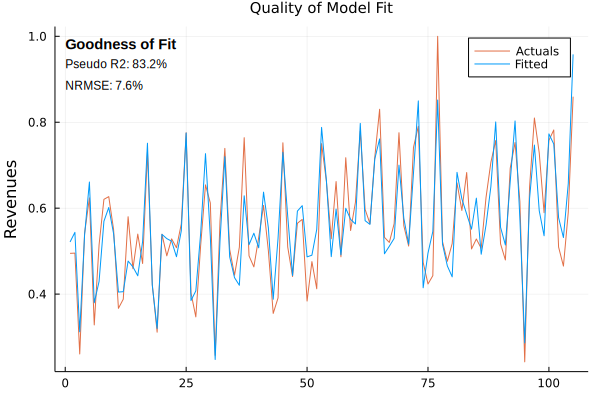

In [16]:
pred_vals_stage1 = predict(model_orig_stage1, chain_stage1,include_all=false);
y_pred_stage1=mean(pred_vals_stage1.value.data,dims=(1,3))|>vec;
plot_model_fit_by_period(y_std,y_pred_stage1,ParamsPlot())

### MAP (Alternative)
If NUTS is taking long time, you can just run MAP and use the below chain object for the stage1fit (it tends to be good enough)

In [17]:
# @time map_estimate = Optim.optimize(cond_model, MAP())

In [18]:
# dim=size(map_estimate.values,1)
# chain_map=Chains(repeat(reshape(collect(map_estimate.values),1,dim,1),outer=(100,)),
#             names(map_estimate.values)[1]);
# pred_vals_map = predict(model_orig, chain_map,include_all=false);
# y_pred_map=mean(pred_vals_map.value.data,dims=(1,3))|>vec;

# @printf("R2: %.1f%% \n",myr2(y_std,y_pred_map)*100)
# @printf("RMSE: %.1f \n",rmse(y_std,y_pred_map))
# @printf("NRMSE: %.1f%% \n",nrmse(y_std,y_pred_map)*100)

In [19]:
# chain_stage1=chain_map

## Stage 2 - Marketing drivers

Let's use the fit from the first stage and focus mostly on the marketing variables (including their adstock/saturation transformations)

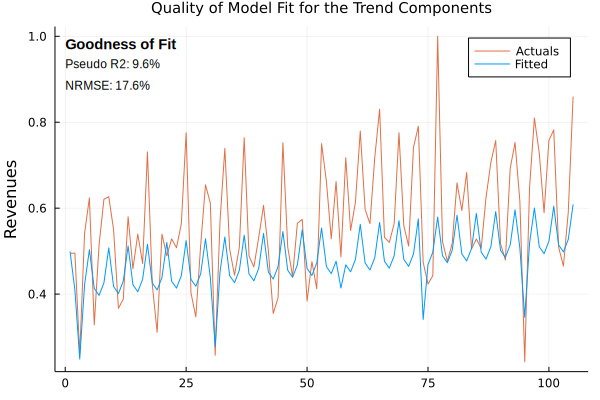

In [55]:
stage1_fit=generated_quantities(model_orig_stage1,Chains(chain_stage1,:parameters));
stage1_fit=mean([hcat(tup.mu_trend,tup.mu_hols,tup.mu_seas,tup.mu_cat) for tup in stage1_fit]);
y_pred=sum(stage1_fit,dims=2)|>vec

plot_model_fit_by_period(y_std,y_pred,
    ParamsPlot(title_suffix=" for the Trend Components"))

### Model

┌ Info: Key scales_context: 0.14 | 0.14
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/model_priors.jl:104
┌ Info: Key scales_org: 0.49
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/model_priors.jl:104
┌ Info: Hill Curve: 
│ adspend_mean_nonzero: 0.49 | 0.75 | 0.50
│ adspend_median: 0.45 | 0.58 | 0.47
│ locs_spend_halfmaxpoint: 0.49 | 0.75 | 0.50
│ scales_spend_halfmaxpoint: 0.30 | 0.30 | 0.30
│ locs_spend_beta: 1.00 | 1.00 | 1.00
│ scales_spend_beta: 1.50 | 1.50 | 1.50
│ units_ratio_spend_to_y: 0.02 | 0.06 | 0.03
│ factor_to_roas_of_one: 0.05 | 0.12 | 0.06
└ @ MediaMixModellingDemo /Users/simljx/Documents/julia-con-2022/MediaMixModellingDemo/src/model_priors.jl:275
┌ Info: Decay Rates: 
│ facebook_S: Mean 0.09 | Range 0.01-0.26 | Halflife 0.29 periods
│ tv_S: Mean 0.56 | Range 0.43-0.67 | Halflife 1.18 periods
│ search_S: Mean 0.09 | Range 0.01-0.26 | Halflife 0.29 periods
└ @ MediaMixModellingDem

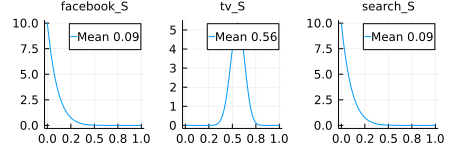

In [22]:
p2=ParamsStage2(
    model_name=Val(Symbol(MODEL_NAME)),
    scales_trend_offset=0.3,
    scales_trend=0.2,
    scales_noise=0.3,
)

p2 = set_priors_auto_scales(y_std,X_context,:scales_context,1.0,p2)
p2 = set_priors_auto_scales(y_std,X_org,:scales_org,1.0,p2)
p2 = set_priors_stage2_hill_curves(X_spend,p2;
        units_ratio_spend_to_y=getindex.(pipe_cache_spend,:xh)/pipe_cache_y[1].xh,
        halfmaxpoint_scale=0.3,expected_roas=1.0, expected_roas_scale=1.5)
p2 = set_priors_stage2_decay_rates(["digital","tv","digital"],decay_rates_types_dictionary,p2,cols_spend)

sanity_check_priors(p2;X_spend,X_context,X_org);

# quick check of decay_rate priors
plot_priors_decay_rate(p2,cols_spend)

### NUTS

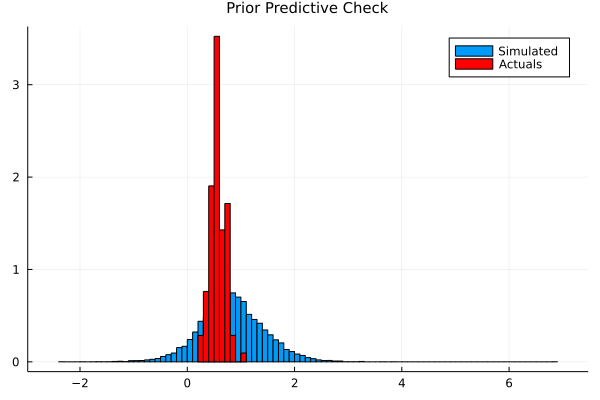

In [23]:
############
model_orig=model_func_stage2(
    to_masked_matrix(time_std,FITTING_MASK),
    to_masked_matrix(stage1_fit,FITTING_MASK),
    to_masked_matrix(X_spend,FITTING_MASK),
    to_masked_matrix(X_org,FITTING_MASK),
    to_masked_matrix(X_context,FITTING_MASK),
    p2);

y_std_masked=to_masked_matrix(y_std,FITTING_MASK)

cond_model=model_orig | (;y=y_std_masked);
y_prior=mapreduce(x->rand(model_orig).y,hcat,1:100)|>vec
plot_prior_predictive_histogram(y_std_masked,y_prior,ParamsPlot())

In [24]:
# used to benchmark implementation of the core function

@btime cond_model.f(
    cond_model,
    Turing.VarInfo(cond_model),
    Turing.SamplingContext(
        Random.GLOBAL_RNG, Turing.SampleFromPrior(), cond_model.context,
    ),
    cond_model.args...,
);

  356.083 μs (4903 allocations: 197.86 KiB)


In [25]:
max_depth=10
metricT=AHMC.DiagEuclideanMetric 
# metricT=AHMC.DenseEuclideanMetric  # optional

with_logger(NullLogger()) do 
    # single chain
    # global chain = sample(cond_model, NUTS(300,0.65;max_depth,metricT),MCMCSerial(),300,1) 
    
    # It's always best to run multiple chains
    global chain = sample(cond_model, NUTS(300,0.65;max_depth,metricT),MCMCThreads(),250,4) 
end

Sampling (4 threads): 100%|█████████████████████████████| Time: 0:00:03


Chains MCMC chain (250×33×4 Array{Float64, 3}):

Iterations        = 301:1:550
Number of chains  = 4
Samples per chain = 250
Wall duration     = 75.61 seconds
Compute duration  = 288.87 seconds
parameters        = trend_offset, beta_trend[1], beta_trend[2], beta_trend[3], beta_trend[4], beta_spend[1], beta_spend[2], beta_spend[3], decay_rate[1], decay_rate[2], decay_rate[3], slope[1], slope[2], slope[3], halfmaxpoint[1], halfmaxpoint[2], halfmaxpoint[3], beta_org[1], beta_context[1], beta_context[2], sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
       parameters      mean       std   naive_se      mcse         ess      rhat   ess_per_sec 
           Symbol   Float64   Float64    Float64   Float64     Float64   Float64       Float64 

     trend_offset   -0.0577    0.0820     0.0026    0.0028    695.4162 

In [26]:
quick_nuts_diagnostics(chain,max_depth)

Acceptance rate is: 85.9%
Number of all numerical errors: 0.0
Number of transitions that exceeded max depth of 10: 0


In [ ]:
# Diagnostics if the parameter space has been properly explored
# corner(chain[[namesingroup(chain,"slope")...,namesingroup(chain,"decay_rate")...]], 
#     guidefontsize=8,size=(1000,1000))

In [52]:
# Diagnostics if the parameter space has been properly explored
# corner(chain[[namesingroup(chain,"slope")...,namesingroup(chain,"beta_spend")...,Symbol("beta_org[1]")]], 
#     guidefontsize=8,size=(1000,1000))

In [53]:
# Display traceplots -- look for "fuzzy caterpillars"! Any flat lines (ie, chain getting stuck on some values) indicate problems!
# plot(chain)

# Evaluation

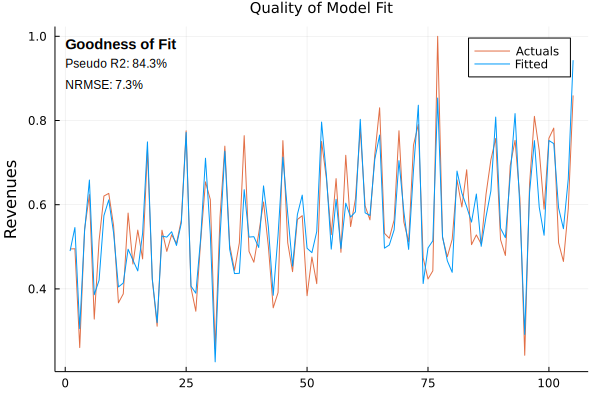

In [30]:
# Generate predictive posterior
y_pred=predict(model_orig, chain,include_all=false) |> x->mean(x.value.data,dims=(1,3))|>vec

plot_model_fit_by_period(y_std,y_pred,ParamsPlot())

In [31]:
stage2_fit_allsamples=generated_quantities(model_orig,Chains(chain,:parameters));

## Model 1-pager

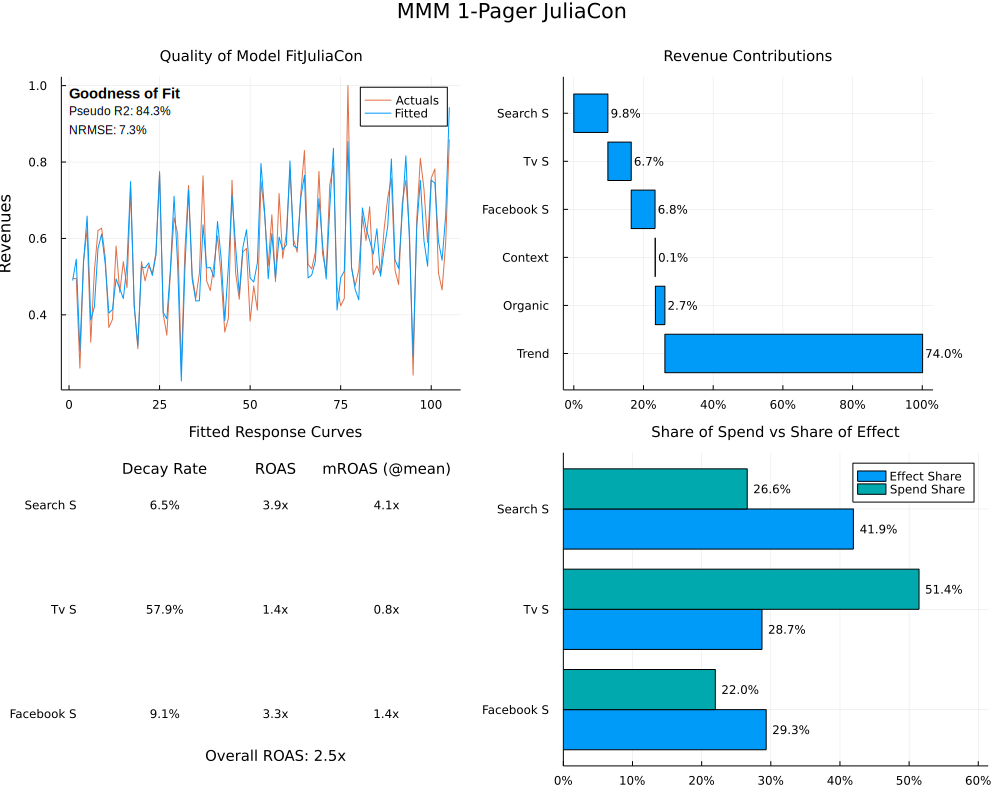

In [32]:
pplot=ParamsPlot(title_suffix=EXPERIMENT_NAME);

# Header
pl0 = plot(title = "MMM 1-Pager "*pplot.title_suffix, grid = false, showaxis = false, ticks=false,bottom_margin = -0Plots.px)

### PLOT 1
pl1=plot_model_fit_by_period(y_std,y_pred,pplot)

### PLOT 2
pl2=let effect_share_mean=mean_fitted_effects(p2.model_name,stage2_fit_allsamples;
             extract_keys=[:mu_trend,:mu_org,:mu_context,:mu_spend_by_var]),
        cols=["Trend","Organic","Context",cols_spend...] .|> prettify_labels

    plot_contributions(effect_share_mean,cols,pplot)
end

### PLOT 3
# extract fitted geometric decay rates
decay_rates=getflatsamples(chain,"decay_rate")|>x->mean(x,dims=1)|>vec
# calculate roas across the whole period
roass=let effects=mean_fitted_effects(p2.model_name,stage2_fit_allsamples;extract_keys=[:mu_spend_by_var]),
    spends=sum_columns(X_spend),
    factors=p2.units_ratio_spend_to_y
    
    calc_roas.(effects,spends,factors)
end
# calculate mroas at mean spend of each variable with delta of 0.01
mroas_at_means=[calc_mroas(p2.adspend_mean_nonzero[idx],0.01,chain,p2,idx)[1] for idx in 1:length(cols_spend)]

# Total ROAS (depends on model2b used)
roas_total=let effects=mean_fitted_effects(p2.model_name,stage2_fit_allsamples;extract_keys=[:mu_spend_by_var]),
        spends=sum_columns(X_spend),
        factors=p2.units_ratio_spend_to_y,
        weights=revert_pipe_spend(X_spend)|>sum_columns
    
    calc_roas(effects,spends,factors,weights)
end

cols=prettify_labels.(cols_spend)
    
pl3=plot_response_curves_table(decay_rates,roass,mroas_at_means,cols,roas_total,pplot)

### PLOT 4
pl4=let ad_effect_share_mean=(
            mean_fitted_effects(p2.model_name,stage2_fit_allsamples;extract_keys=[:mu_spend_by_var])|>
            percentage_share
        ),
    spend_share=(
        revert_pipe_spend(X_spend)|>sum_columns |> percentage_share
        ),
    cols=prettify_labels.(cols_spend)
    
    plot_effects_vs_spend(ad_effect_share_mean,spend_share,cols,pplot)
end

####################
# 1-Pager

plot_array=[pl0,pl1,pl2,pl3,pl4]

# Save each step
# for i in 1:5
#     pl=plot_mmm_one_pager(plot_array,i,pplot)
    # savefig(pl,joinpath(pwd(),"presentation","assets","mmm-1pager_$(i).png"))
# end;

# show final
pl=plot_mmm_one_pager(plot_array,5,pplot)
# savefig(pl,joinpath(pwd(),"exports","mmm-1pager-$(pplot.title_suffix).png"))
pl

# Optimization

Let's optimize the marketing budget, ie, let's find out by what factor should we increase/decrease our spend on each marketing channel/activity without spending more money overall

In [33]:
# Runs on the whole period at the moment
optim_start=df.dt|>minimum
optim_end=df.dt|>maximum
optim_mask=trues(nrow(df)) 

@assert ((df.dt .>= optim_start) .&& (df.dt .<= optim_end) )|>all

## Metaheuristics loop

In [34]:
# Prepare inputs
chain_optim=Chains(chain,:parameters)
simulations_prev=simulate_revenues_summed(chain_optim,model_orig,optim_mask;extract_key=:mu)

# boundaries on possible solution
lower_bound = 0.5*ones(length(cols_spend)) # max 50% reduction
upper_bound = 1.5*ones(length(cols_spend)) # max 50% increase
bounds = [lower_bound upper_bound]'

# Bayesian Decision Theory -- how to weigh the outcomes across the posterior distribution
# define a simple asymmetric (risk-averse) loss function
loss_func(x)=x>0 ? 0.5x : x
# plot(loss_func,-2,2) # to review it

# All channels must have some spend in the optimization period!
@assert all((@view(X_spend[optim_mask,:])|>sum_columns) .>0)

# Method with direct budget multiplier
# spend_raw_sum is masked with optim_mask!
spend_raw_sum=revert_pipe_spend(X_spend[optim_mask,:])|>sum_columns

objective_func=generate_objective_func(
    chain_optim,model_orig,Matrix(X_spend),optim_mask,
    spend_raw_sum,loss_func;simulations_basecase=simulations_prev,extract_key=:mu)

#126 (generic function with 1 method)

In [35]:
# time_limit is in seconds
# debug = true if you want to see each iteration
# parallel_evaluation = true if you have batch-enabled objective function (see docs for `threaded_objective_func`)
options = Metaheuristics.Options(time_limit=60.,debug=false,parallel_evaluation=true)

# Set K parameter as the original paper
# Note: authors were running maximum evaluations = 10000 * number_of_dimensions
# Source: https://www.researchgate.net/publication/327631987_A_New_Evolutionary_Optimization_Method_Based_on_Center_of_Mass_Performance_and_Safety_Management

### Single-thread version
# @time result = Metaheuristics.optimize(objective_func, bounds, 
#     Metaheuristics.ECA(N=7*2*length(cols_spend),K=7,η_max=2.,options=options))

### Parallelized version
@time result = Metaheuristics.optimize(x->threaded_objective_func(x,objective_func), 
    bounds, 
    Metaheuristics.ECA(N=7*2*length(cols_spend),K=7,η_max=2.,options=options))

 62.713203 seconds (2.51 G allocations: 104.340 GiB, 17.42% gc time, 5.62% compilation time)


+=========== RESULT ==========+
  iteration: 26
    minimum: -0.927272
  minimizer: [1.3665690340442602, 0.58502455952184, 1.4997321042828584]
    f calls: 1092
  feasibles: 42 / 42 in final population
 total time: 60.8620 s
stop reason: Maximum time exceeded.
+============================+

In [36]:
@show Metaheuristics.minimum(result)
@show Metaheuristics.minimizer(result)

############################
### TRANSFORM THE OPTIMUM
loss_optim=Metaheuristics.minimum(result)
budget_multiplier_optim=Metaheuristics.minimizer(result);

# Careful: X_spend_optim_trf is not subset to optim_mask!
X_spend_optim_trf=copy(X_spend)
X_spend_optim_trf[optim_mask,:] .*= budget_multiplier_optim';

# replace the old spend with new and run the simulation
model_args_new=merge(model_orig.args,(;X_spend=to_masked_matrix(X_spend_optim_trf,optim_mask)))
simulations_optim=generated_quantities(model_stage2a(model_args_new...),chain_optim);

#############################
# Optimization smell tests

# check that the ad spend is the same 
let new_spend_sum=revert_pipe_spend(X_spend_optim_trf)|>Matrix|>sum,
        check_total_spend1=revert_pipe_spend(X_spend)|>Matrix|>sum
    
    @assert check_total_spend1 >= new_spend_sum "Error: Ad spend has increased ($(check_total_spend1) vs $(new_spend_sum))"
end

let new_spend_sum=revert_pipe_spend(X_spend_optim_trf)|>Matrix|>sum,
        check_total_spend2=sum(Matrix(df[!,cols_spend]))
    
    @assert check_total_spend2 >= new_spend_sum "Error: Ad spend has increased ($(check_total_spend2) vs $(new_spend_sum))"
    @assert check_total_spend2*0.95 < new_spend_sum "Error: Ad spend has decreased by more than 5%! ($(check_total_spend2) vs $(new_spend_sum))"
end

# check spend_multiplier that it's within bounds
@assert all(bounds'[:,1] .<= budget_multiplier_optim .<= bounds'[:,2])

# Mean difference against the known revenues should not be negative 
# because expected value of noise is zero, minimizer routine should prefer the same solution
let simulated_y=mean_fitted_effects(p2.model_name,simulations_optim;extract_keys=[:y],mask=optim_mask)[1]
    @assert (simulated_y .- sum(y_std[optim_mask,:])) > 0 "Suspicious: New optimum is lower than original revenues! Investigate!"
end

Metaheuristics.minimum(result) = -0.9272719494457535
Metaheuristics.minimizer(result) = [1.3665690340442602, 0.58502455952184, 1.4997321042828584]


## 1-Pager

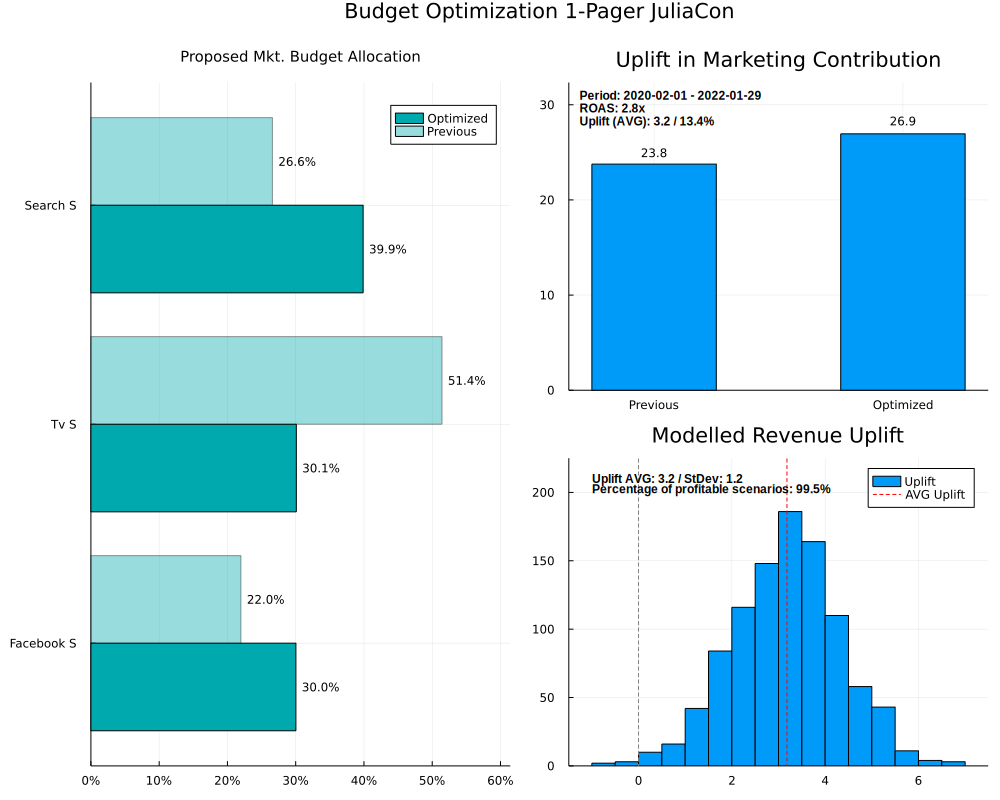

In [51]:
# Header
pl0 = plot(title = "Budget Optimization 1-Pager "*pplot.title_suffix, grid = false, showaxis = false, ticks=false,bottom_margin = -0Plots.px)

###
pl1=let spend_share_prev=revert_pipe_spend(X_spend) |> x->to_masked_matrix(x,optim_mask) |> sum_columns |> percentage_share,
    spend_share_optim=revert_pipe_spend(X_spend_optim_trf) |> x->to_masked_matrix(x,optim_mask) |> sum_columns |> percentage_share,
    cols=prettify_labels.(cols_spend)

    plot_optimized_spend_share_comparison(spend_share_prev,spend_share_optim,cols,pplot)
end

### 
# Total ROAS (depends on model2b used)
roas_total=let effects=mean_fitted_effects(p2.model_name,simulations_optim;extract_keys=[:mu_spend_by_var]),
        spends=sum_columns(X_spend),
        factors=p2.units_ratio_spend_to_y,
        weights=revert_pipe_spend(X_spend)|>sum_columns
    
    calc_roas(effects,spends,factors,weights)
end
pl2=let roas_total=roas_total,
    effect_prev=mean_fitted_effects(p2.model_name,stage2_fit_allsamples;extract_keys=[:mu_spend],mask=optim_mask)[1],
    effect_optim=mean_fitted_effects(p2.model_name,simulations_optim;extract_keys=[:mu_spend],mask=optim_mask)[1]

    plot_optimized_contribution(effect_prev,effect_optim,roas_total,optim_start,optim_end,revert_pipe_y,pplot)
end

###
pl3=let simulations_prev=simulate_revenues_summed(chain_optim,model_orig,optim_mask;extract_key=:mu),
    simulations_optimized=simulate_revenues_summed(chain_optim,model_orig.f(model_args_new...),optim_mask;extract_key=:mu)

    revenue_uplift=revert_pipe_y(simulations_optimized .- simulations_prev)

    plot_optimized_uplift_histogram(revenue_uplift,pplot)
end

####################
# 1-Pager

plot_array=[pl0,pl1,pl2,pl3]

# Save each step
# for i in 1:length(plot_array)
#     pl=plot_optimization_one_pager(plot_array,i,pplot)
    # savefig(pl,joinpath(pwd(),"presentation","assets","optimization-1pager_$(i).png"))
# end;

# show final
pl=plot_optimization_one_pager(plot_array,4,pplot)
# savefig(pl,joinpath(pwd(),"exports","optimization-1pager-$(pplot.title_suffix).png"))
pl

# END